# Notebook: First data exploration and preprocessing

This notebook contains a first exploration of the data and insights that led to further modeling choices.
> Insights or observations made on the data are in blockquotes as the present one.

## Necessary imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

%matplotlib inline

# Data preprocessing

## Load data

In [2]:
# Read the data
train_timeseries = pd.read_csv('../data/train_timeseries.csv')
val_timeseries = pd.read_csv('../data/validation_timeseries.csv')
test_timeseries = pd.read_csv('../data/test_timeseries.csv')
soil_data = pd.read_csv('../data/soil_data.csv')

## Analyze train timeseries

In [3]:
train_timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [4]:
display(train_timeseries.head())
# Check that the data is complete and that for every fips we have the same amount of data
print(train_timeseries.shape)
n_fips = len(pd.unique(train_timeseries['fips']))
n_date = len(pd.unique(train_timeseries['date']))
print("number of dates: ", n_date, "; number of fips: ", n_fips, "; number of points: ",train_timeseries.shape[0], "; difference between n_fips*n_date and the number of points: ",n_date * n_fips - train_timeseries.shape[0])

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


(19300680, 21)
number of dates:  6210 ; number of fips:  3108 ; number of points:  19300680 ; difference between n_fips*n_date and the number of points:  0


There are 757 `fips` and 6120 different `dates`. However, in the data there are 4433 less rows than if every `fips` had 6210 rows of data.
We try to find out what data is missing.

In [5]:
print(pd.unique(train_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data  that can be found for each fips
train_timeseries.groupby('fips').count()['date'][train_timeseries.groupby('fips').count()['date'] < 6000] #what fips have less than 6000 rows of data?

[6210]


Series([], Name: date, dtype: int64)

`fips` #19003 lacks data compared to the others in the `train_timeseries`. If it is the case in the `val_timeseries` as well as in the `test_timeseries`, then we will drop all data concerning this region in order to keep as much flexibility for models to come.

In [6]:
print(pd.unique(train_timeseries.groupby('fips').min()['date']))
print(pd.unique(train_timeseries.groupby('fips').max()['date']))

['2000-01-01']
['2016-12-31']


See if there are `fips` codes in the `val` and `test` timeseries that do not appear in the `train` timeseries.

In [7]:
print(len(pd.unique(train_timeseries['fips'])))
print(len(pd.unique(val_timeseries['fips'])))
print(len(pd.unique(test_timeseries['fips'])))
# Check that the val and test timeseries contain exactly the same fips codes
print(sum(pd.unique(val_timeseries['fips']) == pd.unique(test_timeseries['fips'])) == len(pd.unique(test_timeseries['fips'])))

3108
3108
3108
True


In [8]:
print(pd.unique(val_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data that can be found for each fips
print(pd.unique(test_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data that can be found for each fips
# No imbalance problem in the val and test timeseries: all fips have the same amounf of data

[730]
[731]


In [9]:
# Check that for all fips, the data in val and test spans accross the sames dates
print(pd.unique(val_timeseries.groupby('fips').min()['date']))
print(pd.unique(val_timeseries.groupby('fips').max()['date']))
print(pd.unique(test_timeseries.groupby('fips').min()['date']))
print(pd.unique(test_timeseries.groupby('fips').max()['date']))

['2017-01-01']
['2018-12-31']
['2019-01-01']
['2020-12-31']


Check for NaN values in all columns except for the `score` one.

In [10]:
train_timeseries.drop(columns = ['score']).isna().values.any()

False

Check for obvious outliers

In [11]:
train_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,2.756796e+06
mean,3.067038e+04,2.644145e+00,9.665578e+01,7.816178e+00,1.280146e+01,6.951072e+00,6.986916e+00,1.868141e+01,7.411665e+00,1.126974e+01,1.288900e+01,3.564013e+00,5.195993e+00,1.928879e+00,3.267113e+00,5.525151e+00,7.811798e+00,3.130077e+00,4.681721e+00,8.245298e-01
std,1.497911e+04,6.226305e+00,5.447994e+00,4.694305e+00,1.092674e+01,1.014551e+01,1.009116e+01,1.154487e+01,1.057680e+01,4.005165e+00,1.114961e+01,1.862297e+00,2.627969e+00,1.351713e+00,1.947028e+00,2.321549e+00,2.861210e+00,2.122751e+00,2.171263e+00,1.223727e+00
min,1.001000e+03,0.000000e+00,6.612000e+01,1.200000e-01,-3.734000e+01,-3.770000e+01,-3.746000e+01,-3.220000e+01,-4.596000e+01,3.000000e-02,-3.823000e+01,2.500000e-01,5.400000e-01,0.000000e+00,1.600000e-01,4.000000e-01,7.000000e-01,0.000000e+00,3.200000e-01,0.000000e+00
25%,1.904450e+04,0.000000e+00,9.584000e+01,3.780000e+00,4.450000e+00,-9.600000e-01,-9.200000e-01,1.027000e+01,-7.000000e-01,8.420000e+00,4.340000e+00,2.140000e+00,3.110000e+00,9.600000e-01,1.810000e+00,3.790000e+00,5.680000e+00,1.450000e+00,3.130000e+00,0.000000e+00
50%,2.921200e+04,1.800000e-01,9.830000e+01,6.840000e+00,1.402000e+01,7.570000e+00,7.580000e+00,2.040000e+01,8.030000e+00,1.124000e+01,1.404000e+01,3.140000e+00,4.670000e+00,1.660000e+00,2.800000e+00,5.120000e+00,7.310000e+00,2.770000e+00,4.250000e+00,0.000000e+00
75%,4.600750e+04,2.160000e+00,9.996000e+01,1.135000e+01,2.188000e+01,1.552000e+01,1.552000e+01,2.787000e+01,1.614000e+01,1.408000e+01,2.207000e+01,4.600000e+00,6.750000e+00,2.580000e+00,4.250000e+00,6.880000e+00,9.460000e+00,4.410000e+00,5.770000e+00,1.189600e+00
max,5.604300e+04,2.345900e+02,1.043200e+02,2.292000e+01,4.139000e+01,2.755000e+01,2.755000e+01,4.991000e+01,3.380000e+01,3.461000e+01,4.385000e+01,2.369000e+01,3.628000e+01,1.720000e+01,2.825000e+01,2.835000e+01,4.273000e+01,2.087000e+01,3.243000e+01,5.000000e+00


`PRECTOT` has a max value far from its 3rd quartile. We check it it looks like an error or like normal values

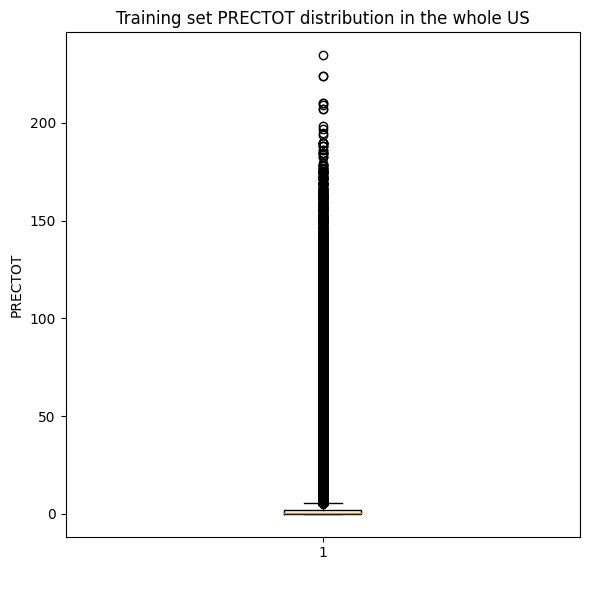

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot(train_timeseries['PRECTOT'])
ax.set_xlabel(" ")
ax.set_ylabel("PRECTOT")
ax.set_title("Training set PRECTOT distribution in the whole US")
plt.tight_layout()
# It looks like there are a lot of outliers but that seem to be correct

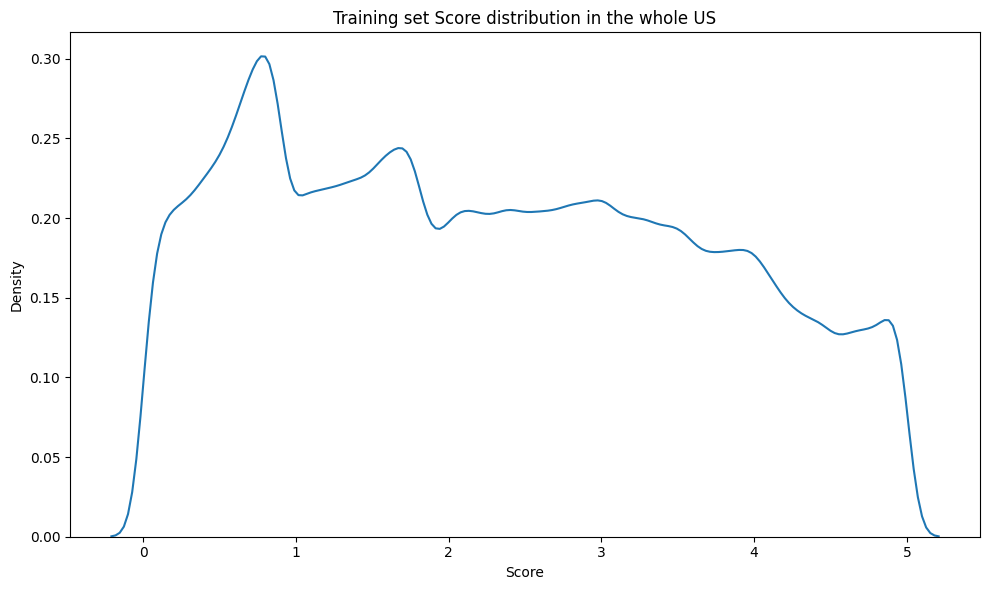

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(pd.unique(train_timeseries['score']), bw_method = 0.05, ax = ax)
ax.set_xlabel("Score")
ax.set_ylabel("Density")
ax.set_title("Training set Score distribution in the whole US")
plt.tight_layout()

> The score data is not perfectly balanced but not enough for downsampling/upsampling to be our top priority.

## Analzse Validation and Test Timeseries

In [14]:
# Check for any missing value in all independent variables
print(val_timeseries.drop(columns = ['score']).isna().values.any())
print(test_timeseries.drop(columns = ['score']).isna().values.any())

False
False


In [15]:
val_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,323232.000000
mean,3.067038e+04,2.945218e+00,9.668289e+01,8.209934e+00,1.313680e+01,7.626656e+00,7.631953e+00,1.884739e+01,7.903998e+00,1.094340e+01,1.321793e+01,3.533742e+00,5.165298e+00,1.904352e+00,3.260947e+00,5.486969e+00,7.762958e+00,3.104674e+00,4.658297e+00,0.538601
std,1.497911e+04,6.883588e+00,5.443892e+00,4.905189e+00,1.093575e+01,1.049740e+01,1.035683e+01,1.151619e+01,1.064708e+01,3.951253e+00,1.113432e+01,1.845010e+00,2.607319e+00,1.342821e+00,1.927159e+00,2.310433e+00,2.851491e+00,2.115034e+00,2.155684e+00,0.916711
min,1.001000e+03,0.000000e+00,6.686000e+01,1.600000e-01,-3.329000e+01,-3.701000e+01,-3.358000e+01,-2.859000e+01,-3.815000e+01,2.000000e-02,-3.548000e+01,3.700000e-01,6.000000e-01,0.000000e+00,2.200000e-01,4.600000e-01,8.700000e-01,0.000000e+00,3.000000e-01,0.000000
25%,1.904450e+04,0.000000e+00,9.588000e+01,3.920000e+00,4.670000e+00,-4.400000e-01,-4.800000e-01,1.035000e+01,-4.400000e-01,8.140000e+00,4.540000e+00,2.120000e+00,3.110000e+00,9.400000e-01,1.810000e+00,3.770000e+00,5.640000e+00,1.420000e+00,3.110000e+00,0.000000
50%,2.921200e+04,1.900000e-01,9.832000e+01,7.260000e+00,1.458000e+01,8.510000e+00,8.420000e+00,2.081000e+01,8.670000e+00,1.090000e+01,1.461000e+01,3.140000e+00,4.670000e+00,1.640000e+00,2.810000e+00,5.120000e+00,7.300000e+00,2.760000e+00,4.220000e+00,0.000000
75%,4.600750e+04,2.500000e+00,9.998000e+01,1.218000e+01,2.251000e+01,1.671000e+01,1.665000e+01,2.824000e+01,1.701000e+01,1.364000e+01,2.269000e+01,4.560000e+00,6.710000e+00,2.560000e+00,4.250000e+00,6.830000e+00,9.420000e+00,4.390000e+00,5.760000e+00,1.000000
max,5.604300e+04,2.433200e+02,1.040600e+02,2.198000e+01,4.062000e+01,2.684000e+01,2.684000e+01,5.003000e+01,3.304000e+01,3.319000e+01,4.325000e+01,2.494000e+01,3.176000e+01,1.629000e+01,2.319000e+01,2.952000e+01,3.738000e+01,2.085000e+01,2.890000e+01,5.000000


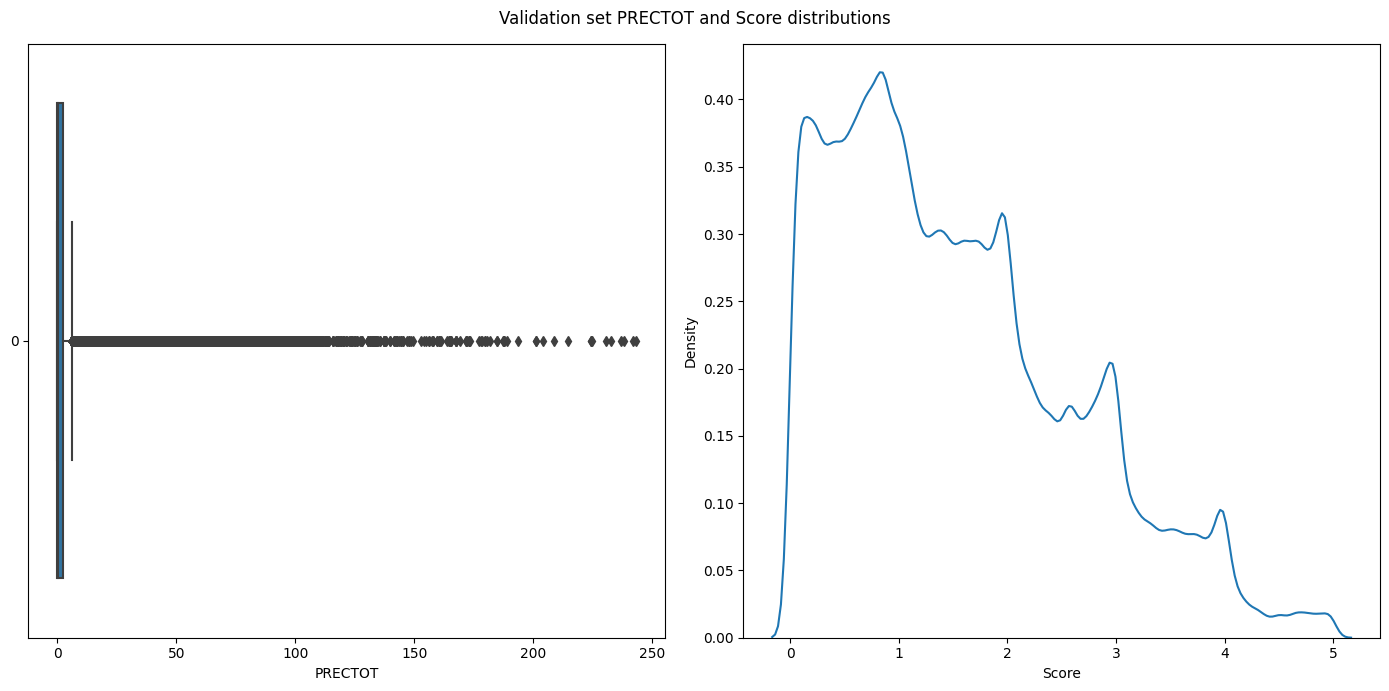

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
sns.boxplot(val_timeseries['PRECTOT'], orient = "h", ax = ax1)
sns.kdeplot(pd.unique(val_timeseries['score']), bw_method = 0.05, ax = ax2)
ax2.set_xlabel("Score")
ax1.set_xlabel("PRECTOT")
plt.suptitle("Validation set PRECTOT and Score distributions")
plt.tight_layout()

In [17]:
test_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,326340.000000
mean,3.067038e+04,2.938845e+00,9.666175e+01,8.223259e+00,1.294575e+01,7.782536e+00,7.793077e+00,1.861224e+01,7.737146e+00,1.087509e+01,1.298156e+01,3.528208e+00,5.177723e+00,1.880345e+00,3.297381e+00,5.486035e+00,7.804205e+00,3.060228e+00,4.743982e+00,0.413486
std,1.497911e+04,6.719112e+00,5.443289e+00,4.925266e+00,1.085940e+01,1.033316e+01,1.010450e+01,1.140387e+01,1.063210e+01,3.850620e+00,1.106347e+01,1.834560e+00,2.618564e+00,1.310424e+00,1.971088e+00,2.291324e+00,2.869980e+00,2.071117e+00,2.202233e+00,0.838403
min,1.001000e+03,0.000000e+00,6.675000e+01,1.000000e-01,-3.857000e+01,-4.154000e+01,-3.859000e+01,-3.133000e+01,-4.546000e+01,1.200000e-01,-4.123000e+01,2.600000e-01,6.000000e-01,0.000000e+00,2.300000e-01,5.200000e-01,1.040000e+00,0.000000e+00,4.500000e-01,0.000000
25%,1.904450e+04,0.000000e+00,9.586000e+01,3.960000e+00,4.530000e+00,-1.600000e-01,-1.100000e-01,1.018000e+01,-5.000000e-01,8.140000e+00,4.410000e+00,2.120000e+00,3.110000e+00,9.400000e-01,1.820000e+00,3.790000e+00,5.670000e+00,1.410000e+00,3.160000e+00,0.000000
50%,2.921200e+04,2.100000e-01,9.830000e+01,7.060000e+00,1.389000e+01,8.250000e+00,8.090000e+00,2.014000e+01,8.080000e+00,1.078000e+01,1.388000e+01,3.140000e+00,4.680000e+00,1.620000e+00,2.820000e+00,5.100000e+00,7.310000e+00,2.720000e+00,4.300000e+00,0.000000
75%,4.600750e+04,2.540000e+00,9.996000e+01,1.222000e+01,2.223000e+01,1.685000e+01,1.671000e+01,2.787000e+01,1.680000e+01,1.353000e+01,2.236000e+01,4.540000e+00,6.710000e+00,2.530000e+00,4.300000e+00,6.820000e+00,9.450000e+00,4.320000e+00,5.860000e+00,0.406525
max,5.604300e+04,2.493400e+02,1.038800e+02,2.252000e+01,4.033000e+01,2.705000e+01,2.700000e+01,4.830000e+01,3.232000e+01,2.965000e+01,4.347000e+01,1.748000e+01,2.497000e+01,1.651000e+01,2.207000e+01,2.058000e+01,2.993000e+01,1.922000e+01,2.634000e+01,5.000000


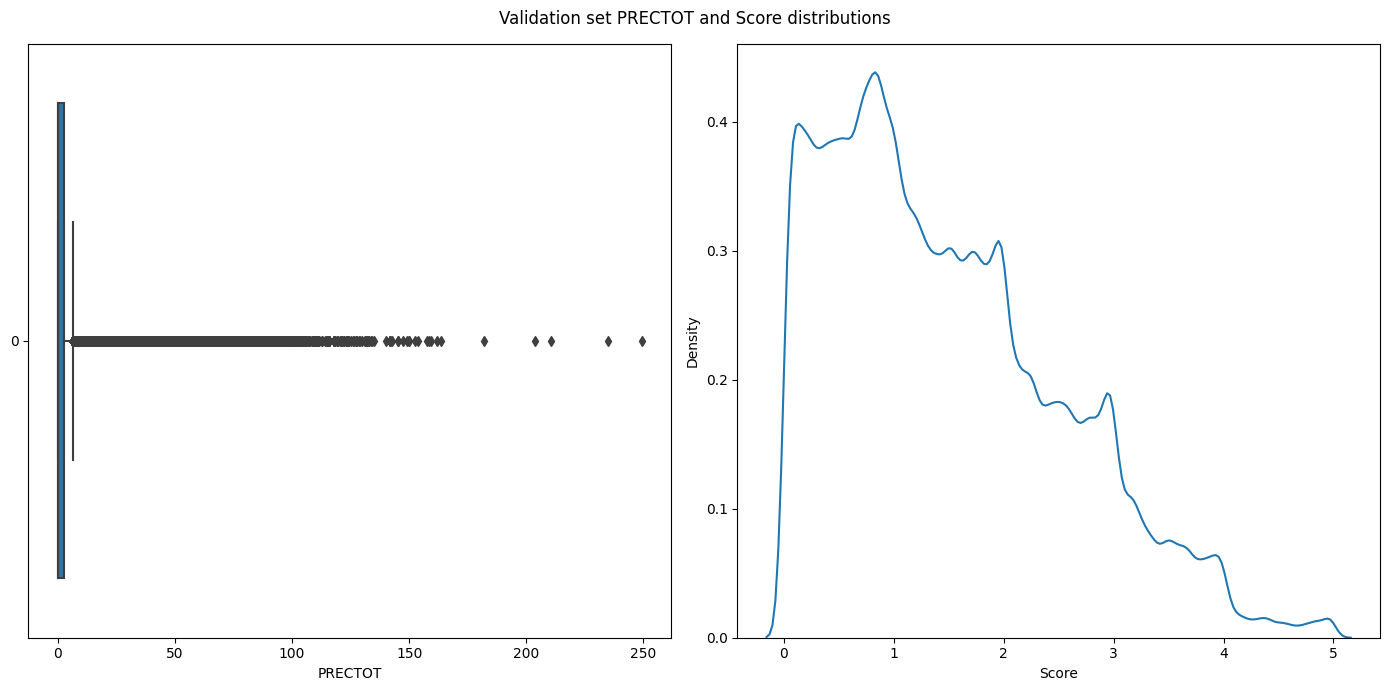

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
sns.boxplot(test_timeseries['PRECTOT'], orient = "h", ax = ax1)
sns.kdeplot(pd.unique(test_timeseries['score']), bw_method = 0.05, ax = ax2)
ax2.set_xlabel("Score")
ax1.set_xlabel("PRECTOT")
plt.suptitle("Validation set PRECTOT and Score distributions")
plt.tight_layout()

## Interpolate Drought score for Train, Validation and Test Timeseries

We plot below:
- True values of score on `fips` 1001 and on the first 1000 data points
- Linear interpolation of score on `fips` 1001 and on the first 1000 data points
- Polynomial (order 2) interpolation of score on `fips` 1001 and on the first 1000 data points

In [19]:
train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score']

0      NaN
1      NaN
2      NaN
3      1.0
4      NaN
      ... 
995    NaN
996    NaN
997    2.0
998    NaN
999    NaN
Name: score, Length: 1000, dtype: float64

/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


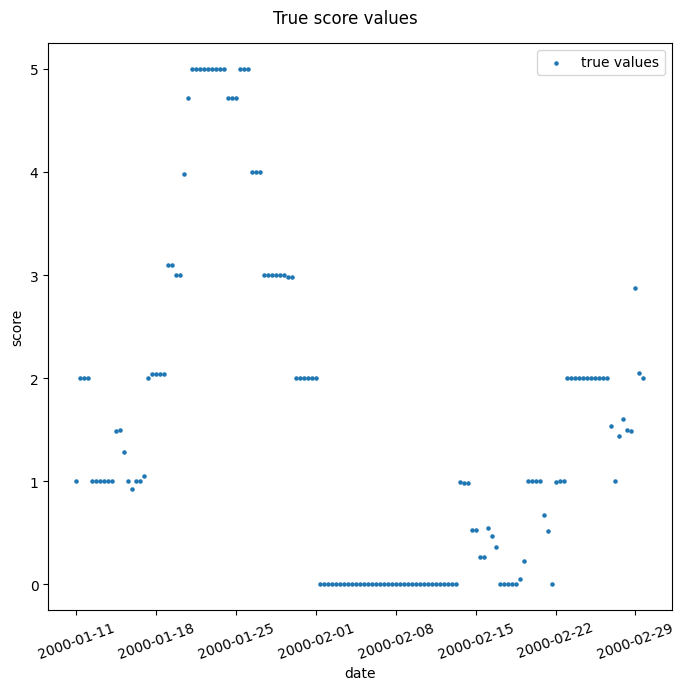

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))
X = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000].dropna(axis="index")['date']
y = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000].dropna(axis="index")['score']
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.set_xticklabels(X[list(range(3, 1000, 7))], rotation=20)
ax.set_ylabel("score")
ax.set_xlabel("date")
ax.scatter(X, y, s=5, label="true values")
plt.suptitle("True score values")
plt.legend(loc="best")
plt.tight_layout()

/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


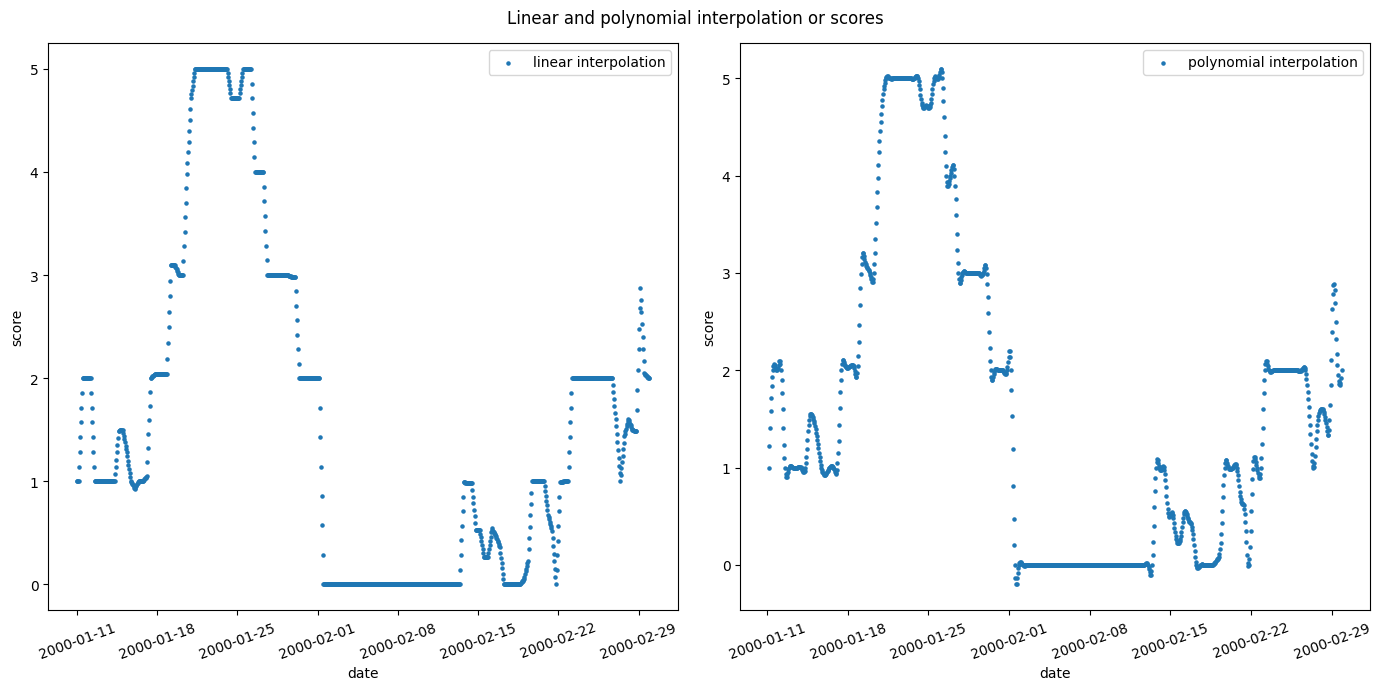

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

X_1 = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['date']
y_1 = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score'].interpolate(method = "linear", limit_direction = "both")
ax1.xaxis.set_major_locator(MultipleLocator(140))
ax1.set_xticklabels(X_1[range(3, 1000, 7)], rotation=20)
ax1.set_ylabel("score")
ax1.set_xlabel("date")
ax1.scatter(X_1, y_1, s=5, label="linear interpolation")
ax1.legend(loc="best")

X_2 = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['date']
y_2 = train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score'].interpolate(method = "polynomial", order = 2, limit_direction = "both")
ax2.xaxis.set_major_locator(MultipleLocator(140))
ax2.set_xticklabels(X_2[range(3, 1000, 7)], rotation=20)
ax2.set_ylabel("score")
ax2.set_xlabel("date")
ax2.scatter(X_2, y_2, s=5, label="polynomial interpolation")
ax2.legend(loc="best")

plt.suptitle("Linear and polynomial interpolation or scores")
plt.tight_layout()

Given the temporal distribution of the `score` feature, the linear interpolation seems right as it does not produce any aberrant value of `score` (above 5 or below 0).

In [22]:
# Perform the score interpolation for the three datasets
train_timeseries['score'] = (train_timeseries[['fips', 'score']].groupby(['fips']).apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']
val_timeseries['score'] = (val_timeseries[['fips', 'score']].groupby('fips').apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']
test_timeseries['score'] = (test_timeseries[['fips', 'score']].groupby('fips').apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']

> We make the hypothesis that droughts are a slow phenomenon, and that it thus makes sense to interpolate scores linearly between two weekly reported scores. This allows us, at the time of splitting the time series into multiple episodes to populated our training dataset, not to worry about the date an episode starts so that the associated score would indeed be reported (and we would not fall in a NaN score value).

## Analyze Soil Data

In [23]:
print(soil_data.shape)
print(len(pd.unique(soil_data['fips'])))
# Look for any missing value
print(soil_data.isna().values.any())
soil_data.head()

(3109, 32)
3109
False


,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


We have here 3109 `fips` against 3108 in the time series data. we look for the `fips` that does not belong in the time series and drop it before performing our analysis.

In [24]:
fips_not_in_timeseries = list(set(pd.unique(soil_data["fips"])).difference(set(pd.unique(train_timeseries['fips']))))
print(fips_not_in_timeseries)

[56045]


In [25]:
# We drop fips 56045 from our analysis
soil_data = soil_data[~soil_data["fips"].isin(fips_not_in_timeseries)]
print(len(pd.unique(soil_data['fips'])))

3108


Quick description of the data

In [26]:
display(soil_data.iloc[:, :16].describe())
display(soil_data.iloc[:, 16:].describe())

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.00000,3108.000000,3108.000000,3108.000000,3108.000000
mean,30670.376770,38.278261,-91.655636,427.351673,0.054986,0.297783,0.319896,0.155874,0.053425,0.065344,0.022230,0.00927,0.143746,0.168858,0.148378,0.165056
std,14981.517736,4.838381,11.484803,500.007694,0.089884,0.215977,0.167670,0.128420,0.073113,0.125541,0.064136,0.04494,0.078249,0.084102,0.082121,0.087856
min,1001.000000,25.601043,-124.211407,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,19044.500000,34.684992,-98.034999,132.000000,0.008300,0.104850,0.185775,0.040725,0.000500,0.000000,0.000000,0.00000,0.086175,0.109200,0.086275,0.101500
50%,29212.000000,38.325008,-90.180124,271.500000,0.028350,0.271700,0.346950,0.127500,0.012200,0.000700,0.000000,0.00000,0.144200,0.174000,0.148300,0.165500
75%,46007.500000,41.692335,-83.372925,481.500000,0.068525,0.477550,0.459300,0.255225,0.090325,0.054350,0.001200,0.00000,0.195650,0.227375,0.206600,0.223125
max,56043.000000,48.842653,-67.609354,3561.000000,0.974000,0.759900,0.696900,0.571700,0.330000,0.606800,0.476500,0.62880,0.478400,0.738500,0.511200,0.657800


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000
mean,0.352769,2.851428,1.799070,2.670885,19.789316,39.309230,28.503972,3.505807,32.009779,1.830759,1.553732,1.281853,1.357465,1.147040,1.135135,1.284749
std,0.272214,13.161265,7.971982,9.772148,25.419643,34.363826,31.840521,10.292358,33.100006,1.192318,1.021498,1.002587,1.030256,0.922452,0.914646,1.017548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.115600,0.000000,0.000000,0.104828,4.359078,4.575617,0.153979,0.045987,1.612849,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.306050,0.000000,0.000000,0.488500,8.839057,30.709789,14.054533,0.276848,18.812286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.555275,0.000000,0.000000,1.115460,23.711846,74.534248,51.757448,1.370811,60.649996,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,100.000000,99.982918,99.998764,99.998596,91.044609,97.029572,99.956841,99.956841,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


Columns are:
- `fips`, `lat`,`lon`, `elevation`
- `slope` 1 to 8 : percentage of the fips that falls in each slope % (between 0 and 1, sums to 1 for most of the fips)
- `aspect` N, S, E, W, Unkown: percentage of the fips that falls in each category (between 0 and 100, sums to 100 for most of the fips)
- `WAT_LAND`: mapped water bodies
- `NVG_LAND`: sparsely vegetated land
- `URB_LAND`: built up land (resdential and infrastructure)
- `GRS_LAND`: gras/scrub/woodland
- `FOR_LAND`: forest
- `CULTRF_LAND`: rain-fed cultivated land
- `CULTIR_LAND`: irrigated cultivated land
- `CULT_LAND`: total cultivated land (this is the sum of both previous variables)
- `SQ` 1 to 7: each column describes a specific aspect of the soil quality (from 1 to 7: nutrient availability, nutrient retention capacity, rooting conditions, oxygen avilability to roots, excess salts, toxicity, workability). And each one of these attributes is classified (from 1 to 7: No or slight constraints, moderate constraints, severe constraints, very severe constraints, mainly non soil, permafrost area, water bodies)
    

### Slope and Aspect exploration

Check which are the `fips` for which  the `slope` percentages do not sum to 1, and for which  the `aspect` percentages do not sum to 1 or sum to 0.

In [27]:
print(sum(abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1)) < 0.001))

print(sum(abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1)) < 0.001))

121
35
121
35


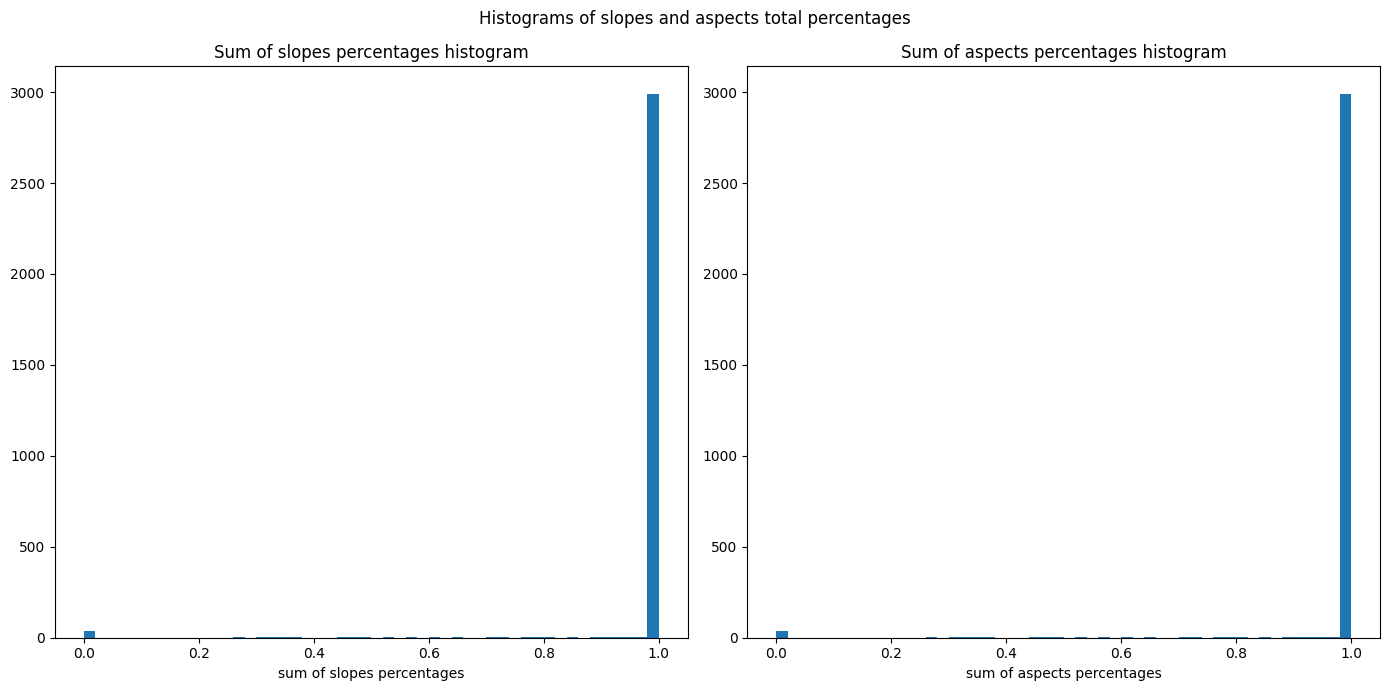

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.hist(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1), bins = 50)
ax1.set_xlabel("sum of slopes percentages")
ax1.set_title("Sum of slopes percentages histogram")
ax2.hist(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1), bins = 50)
ax2.set_xlabel("sum of aspects percentages")
ax2.set_title("Sum of aspects percentages histogram")

plt.suptitle("Histograms of slopes and aspects total percentages")
plt.tight_layout()

In [29]:
display(soil_data[abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,38.921744,-83.525686,25.652893,0.051193,0.202029,0.141972,0.045038,0.008860,0.005240,0.001136,0.000178,0.043864,0.057326,0.047093,0.054142
std,5.785910,11.314912,55.582628,0.076635,0.198374,0.146175,0.069209,0.022394,0.028682,0.010827,0.001873,0.054074,0.066752,0.054039,0.060077
min,26.552134,-123.100616,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.606269,-87.481575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.563855,-81.892250,4.000000,0.025900,0.176700,0.093600,0.010700,0.000100,0.000000,0.000000,0.000000,0.024100,0.036200,0.030000,0.032700
75%,43.458758,-76.162488,16.000000,0.072000,0.339500,0.254100,0.065100,0.003800,0.000500,0.000000,0.000000,0.074500,0.098200,0.077600,0.095200
max,48.508862,-69.038515,292.000000,0.468100,0.645400,0.496200,0.302400,0.140900,0.299200,0.118900,0.020600,0.342400,0.297800,0.252700,0.232000


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.253222,41.135483,0.765421,5.489403,3.202746,13.217629,3.645588,0.372913,4.018501,3.545455,3.479339,3.239669,3.421488,3.214876,3.214876,3.272727
std,0.255955,43.401379,6.955712,18.382208,7.682592,23.140544,8.773417,1.194338,9.249541,3.093003,3.117422,3.224967,3.148418,3.235755,3.235755,3.227486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.213000,19.725800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035098,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,0.404800,100.000000,0.000000,0.605300,3.850647,18.251228,1.189633,0.132908,2.694110,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.927300,100.000000,76.000000,97.305885,55.409653,90.462379,48.940243,10.822440,49.288582,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [30]:
display(soil_data[abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,38.921744,-83.525686,25.652893,0.051193,0.202029,0.141972,0.045038,0.008860,0.005240,0.001136,0.000178,0.043864,0.057326,0.047093,0.054142
std,5.785910,11.314912,55.582628,0.076635,0.198374,0.146175,0.069209,0.022394,0.028682,0.010827,0.001873,0.054074,0.066752,0.054039,0.060077
min,26.552134,-123.100616,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.606269,-87.481575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.563855,-81.892250,4.000000,0.025900,0.176700,0.093600,0.010700,0.000100,0.000000,0.000000,0.000000,0.024100,0.036200,0.030000,0.032700
75%,43.458758,-76.162488,16.000000,0.072000,0.339500,0.254100,0.065100,0.003800,0.000500,0.000000,0.000000,0.074500,0.098200,0.077600,0.095200
max,48.508862,-69.038515,292.000000,0.468100,0.645400,0.496200,0.302400,0.140900,0.299200,0.118900,0.020600,0.342400,0.297800,0.252700,0.232000


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.253222,41.135483,0.765421,5.489403,3.202746,13.217629,3.645588,0.372913,4.018501,3.545455,3.479339,3.239669,3.421488,3.214876,3.214876,3.272727
std,0.255955,43.401379,6.955712,18.382208,7.682592,23.140544,8.773417,1.194338,9.249541,3.093003,3.117422,3.224967,3.148418,3.235755,3.235755,3.227486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.213000,19.725800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035098,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,0.404800,100.000000,0.000000,0.605300,3.850647,18.251228,1.189633,0.132908,2.694110,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.927300,100.000000,76.000000,97.305885,55.409653,90.462379,48.940243,10.822440,49.288582,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In most of the cases, these fips have a high proportion of `WAT_LAND`.

### Land Type exploration

- Check the distribution of the sum of every land type
- Check for which fips ths sum does not add up to 100
- Check that `CULTRF_LAND` and `CULTIR_LAND` sum to `CULT_LAND`

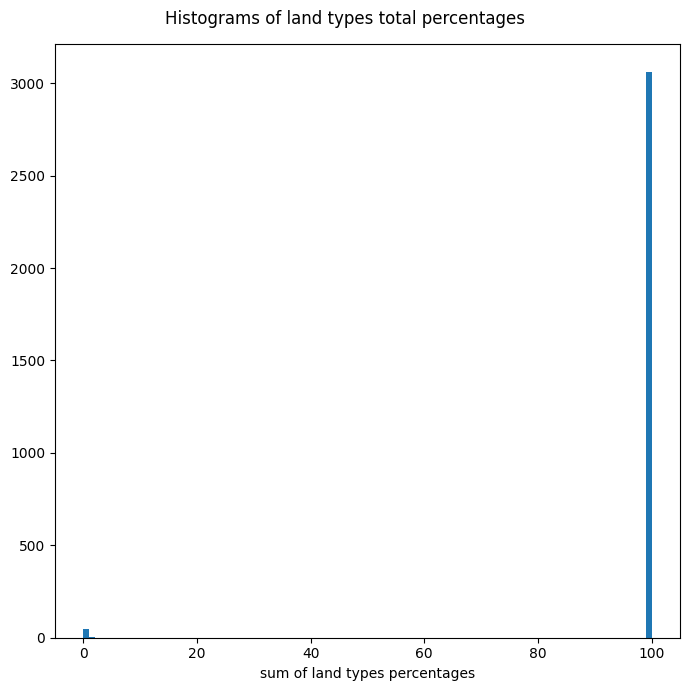

In [31]:
# Distribution of the sum of land types
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.hist(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1), bins = 101)
ax.set_xlabel("sum of land types percentages")

plt.suptitle("Histograms of land types total percentages")
plt.tight_layout()

In [32]:
# For which fips the sum of land types does not add up to 100
display(soil_data[abs(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1) - 100) > 2].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1) - 100) > 2].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,36.508326,-81.681640,11.183673,0.068982,0.286869,0.184473,0.051496,0.009924,0.008959,0.002618,0.000429,0.049955,0.071851,0.062163,0.073931
std,5.052494,13.947290,22.254844,0.064609,0.201433,0.130801,0.061849,0.021027,0.043237,0.016989,0.002942,0.040824,0.057874,0.050275,0.060696
min,28.298276,-123.100616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.358147,-84.799174,2.000000,0.017400,0.109200,0.052500,0.005900,0.000000,0.000000,0.000000,0.000000,0.015700,0.021700,0.017000,0.024000
50%,36.265276,-76.404269,5.000000,0.055800,0.263800,0.176000,0.035800,0.001200,0.000000,0.000000,0.000000,0.041100,0.062000,0.069300,0.067100
75%,40.731384,-73.837929,11.000000,0.098000,0.465700,0.281500,0.076500,0.006700,0.001400,0.000000,0.000000,0.074700,0.103000,0.086900,0.106500
max,48.508862,-68.370703,150.000000,0.314700,0.706900,0.464500,0.255300,0.089800,0.299200,0.118900,0.020600,0.183200,0.233000,0.252700,0.218500


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.000000,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.0
mean,0.355851,0.0,0.0,0.0,0.0,0.0,0.0,0.398610,0.398610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.253100,0.0,0.0,0.0,0.0,0.0,0.0,1.493837,1.493837,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.151400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.302100,0.0,0.0,0.0,0.0,0.0,0.0,0.001138,0.001138,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.557800,0.0,0.0,0.0,0.0,0.0,0.0,0.101333,0.101333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.863200,0.0,0.0,0.0,0.0,0.0,0.0,9.967068,9.967068,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Check that the columns CULTRF_LAND and CULTIR_LAND sum to CULT_LAND
sum(abs(soil_data['CULTRF_LAND'] + soil_data['CULTIR_LAND'] - soil_data['CULT_LAND']) > 0.001)

0

- `fips` for which the land types sum to 0 are `fips`  with bad data (SQ1 to 7 is null; sum of slopes mean does not sum to 1 while it should; land types are almost all 0, and do not sum to 100)
- `CULTRF_LAND` and `CULTIR_LAND` indeed sum to `CULT_LAND`. We thus drop this last column that is not usefull.

In [34]:
soil_data.drop(columns = ['CULT_LAND'], inplace = True)

### Soil Quality exploration

In [35]:
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1].describe().iloc[:, 1:16])
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1].describe().iloc[:, 16:32])

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,36.508326,-81.681640,11.183673,0.068982,0.286869,0.184473,0.051496,0.009924,0.008959,0.002618,0.000429,0.049955,0.071851,0.062163,0.073931
std,5.052494,13.947290,22.254844,0.064609,0.201433,0.130801,0.061849,0.021027,0.043237,0.016989,0.002942,0.040824,0.057874,0.050275,0.060696
min,28.298276,-123.100616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.358147,-84.799174,2.000000,0.017400,0.109200,0.052500,0.005900,0.000000,0.000000,0.000000,0.000000,0.015700,0.021700,0.017000,0.024000
50%,36.265276,-76.404269,5.000000,0.055800,0.263800,0.176000,0.035800,0.001200,0.000000,0.000000,0.000000,0.041100,0.062000,0.069300,0.067100
75%,40.731384,-73.837929,11.000000,0.098000,0.465700,0.281500,0.076500,0.006700,0.001400,0.000000,0.000000,0.074700,0.103000,0.086900,0.106500
max,48.508862,-68.370703,150.000000,0.314700,0.706900,0.464500,0.255300,0.089800,0.299200,0.118900,0.020600,0.183200,0.233000,0.252700,0.218500


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.0
mean,0.355851,0.0,0.0,0.0,0.0,0.0,0.0,0.398610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.253100,0.0,0.0,0.0,0.0,0.0,0.0,1.493837,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.151400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.302100,0.0,0.0,0.0,0.0,0.0,0.0,0.001138,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.557800,0.0,0.0,0.0,0.0,0.0,0.0,0.101333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.863200,0.0,0.0,0.0,0.0,0.0,0.0,9.967068,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- `fips` with SQ that sums to less than 1 are exactly the same as those spotted with problems in land types

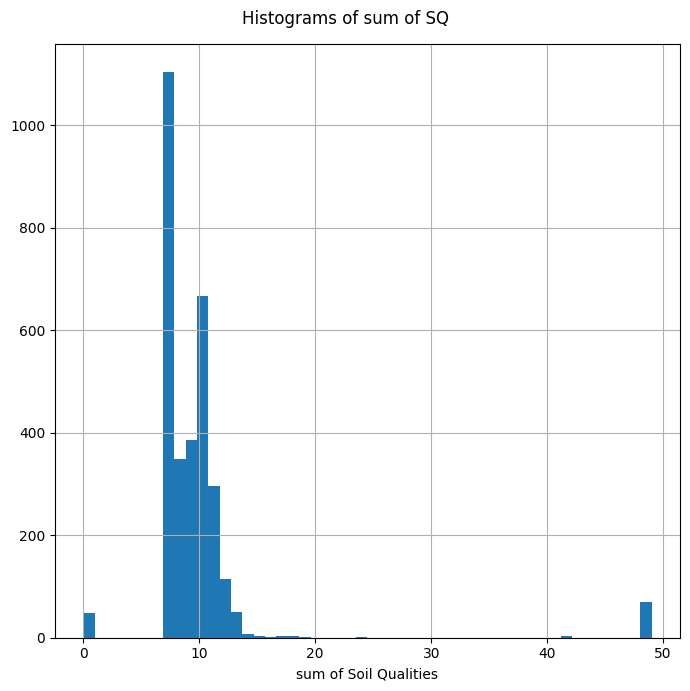

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
(soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']]).sum(axis = 1).hist(bins = 50, ax=ax)
ax.set_xlabel("sum of Soil Qualities")
plt.suptitle("Histograms of sum of SQ")
plt.tight_layout()

In [37]:
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) > 20].iloc[:, 1:16].describe())
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) > 20].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,40.727727,-86.791137,230.635135,0.033449,0.149876,0.149766,0.066557,0.015853,0.019030,0.012958,0.020230,0.058699,0.080145,0.076596,0.068954
std,4.548871,11.162826,706.935923,0.067744,0.182096,0.184443,0.099399,0.034335,0.062745,0.049702,0.100744,0.076229,0.094237,0.102249,0.082775
min,28.445366,-122.746757,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.723142,-87.649612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.657199,-86.125463,5.000000,0.005450,0.043050,0.041900,0.006200,0.000150,0.000000,0.000000,0.000000,0.019800,0.025500,0.015300,0.017100
75%,44.088048,-77.391414,166.750000,0.034900,0.277725,0.265625,0.104400,0.019900,0.001150,0.000000,0.000000,0.104075,0.160750,0.132525,0.139125
max,48.158436,-73.300758,3561.000000,0.343100,0.644400,0.529100,0.382000,0.188000,0.326900,0.261200,0.628800,0.287200,0.301100,0.412800,0.292900


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.183324,66.643162,0.682777,3.869399,4.515802,17.958345,5.162673,1.167842,6.878378,6.878378,6.851351,6.878378,6.851351,6.851351,6.851351
std,0.240226,37.651384,3.109817,13.177896,10.995602,26.265390,11.029489,8.009889,0.522185,0.522185,0.676057,0.522185,0.676057,0.676057,0.676057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000
25%,0.000000,37.821974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
50%,0.048900,79.482300,0.000000,0.000000,0.421900,1.819059,0.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
75%,0.308350,100.000000,0.000000,0.593003,4.731696,30.900002,4.562543,0.144397,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.987500,100.000000,19.999998,94.704834,82.445999,91.044609,47.477272,68.696198,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [38]:
soil_data[soil_data['WAT_LAND'] > 90].describe()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.0,35.0,35.0,35.0,35.0,35.0,35.0
mean,34817.857143,43.903468,-85.043654,26.057143,0.008211,0.034766,0.020943,0.008914,0.001980,0.000589,...,0.152267,0.056294,0.003948,7.0,7.0,7.0,7.0,7.0,7.0,7.0
std,12685.875270,2.225098,3.644812,65.031188,0.034888,0.117357,0.058623,0.038792,0.010656,0.003379,...,0.823373,0.189538,0.022457,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,17097.000000,37.425348,-90.290190,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
25%,26076.000000,42.848211,-87.364252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
50%,26139.000000,43.996636,-86.602967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
75%,45100.000000,45.106995,-83.116733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
max,55117.000000,47.681981,-76.047433,208.000000,0.202000,0.609300,0.227700,0.225100,0.063000,0.020000,...,4.872879,0.809390,0.132908,7.0,7.0,7.0,7.0,7.0,7.0,7.0


- `fips` with all SQ set to 7 are mainly `WAT_LAND`

Given the observations on land types and on SQ, we drop `fips` for which SQ are all 0 and land types are almost all 0.

- Those `fips` were also causing problems in the `slope` and `aspect` columns.
- We thus solve our problem in land types

In [39]:
restr_soil_data = soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) >= 1]

In [40]:
print(sum(abs(restr_soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(restr_soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1)) < 0.001))

print(sum(abs(restr_soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(restr_soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1)) < 0.001))

82
31
82
31


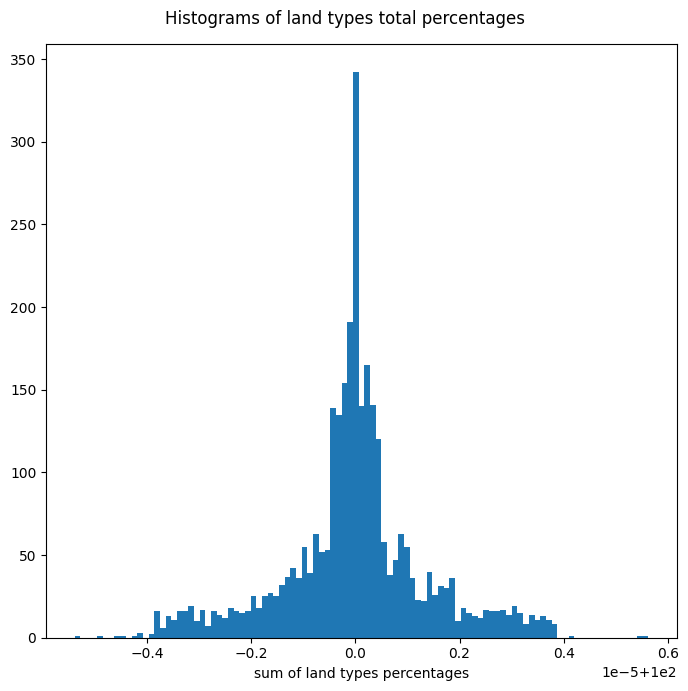

In [41]:
# Distribution of the sum of land types on restricted data
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.hist(restr_soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1), bins = 101)
ax.set_xlabel("sum of land types percentages")
plt.suptitle("Histograms of land types total percentages")
plt.tight_layout()

We now have a distribution with a really low std around 100. We have eliminated the outliers we noticed above.

We look for `fips` codes that are problematic in the soil data perspective.

In [42]:
pd.unique(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1]['fips']).tolist()

[6075,
 6083,
 6087,
 9009,
 12009,
 12037,
 13127,
 13191,
 22023,
 22045,
 22051,
 22075,
 22087,
 22099,
 23009,
 23013,
 23015,
 24047,
 25007,
 25009,
 25019,
 25025,
 28047,
 34009,
 34017,
 36047,
 36059,
 36081,
 36085,
 36103,
 37013,
 37019,
 37029,
 37031,
 37055,
 37095,
 37129,
 37137,
 37139,
 37143,
 44005,
 44009,
 45013,
 45019,
 45043,
 48167,
 51131,
 51810,
 53055]

# Merge time series and soil data

In [46]:
# train_data = pd.merge(train_timeseries, soil_data, on = 'fips', how = 'left')
# train_data.head()
# del train_timeseries

# val_data = pd.merge(val_timeseries, soil_data, on = 'fips', how = 'left')
# val_data.head()
# del val_timeseries

# test_data = pd.merge(test_timeseries, soil_data, on = 'fips', how = 'left')
# test_data.head()
# del test_timeseries
# del soil_data

In [ ]:
print(val_timeseries.shape)
print(val_data.shape)

(2268840, 21)
(2268840, 51)
